In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. 데이터 수집 & 통합

In [3]:
# (1) 날씨 데이터: Daily Minimum Temperatures in Melbourne
weather_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
weather_df = pd.read_csv(weather_url, parse_dates=['Date'])

# 컬럼명 변경: 'Date' -> 'date', 'Temp' -> 'temp'
weather_df.rename(columns={'Date':'date', 'Temp':'temp'}, inplace=True)

In [5]:
# (2) 합성 판매 데이터 생성: weather_df의 날짜를 활용하여 간단한 판매 데이터 생성
sales_df = pd.DataFrame({'date': weather_df['date']})

# 프로모션 여부: 0 또는 1 (80% 확률로 0, 20% 확률로 1)
sales_df['promotion_flag'] = np.random.choice([0, 1], size=len(sales_df), p=[0.8, 0.2])

# 판매량(sales) 생성: 기본값 50, 기온의 영향을 받아 5배, 프로모션 시 추가 20, + 잡은 (정규분포)
sales_df['sales'] = 50 + 5*weather_df['temp'] + 20 * sales_df['promotion_flag'] + np.random.normal(0, 5, len(sales_df))

# 강수량(rainfall): 0 ~ 10 사이의 균등분포 난수로 생성
sales_df['rainfall'] = np.random.uniform(0, 10, len(sales_df))

In [7]:
# (3) 날짜(date)를 기준으로 두 데이터셋 merge (이미 같은 날짜 범위를 사용하므로 1:1 병합)
merged_df = pd.merge(sales_df, weather_df[['date', 'temp']], on='date', how='left')

print("병합 후 데이터 샘플:")
print(merged_df.head())

병합 후 데이터 샘플:
        date  promotion_flag       sales  rainfall  temp
0 1981-01-01               0  155.753040  9.829631  20.7
1 1981-01-02               0  140.107682  3.583607  17.9
2 1981-01-03               0  144.754577  9.705102  18.8
3 1981-01-04               0  127.740318  9.618184  14.6
4 1981-01-05               0  128.751305  8.873008  15.8


# 2. EDA (결측치 처리, 상관관계 확인, 시각화)

In [ ]:
# 결측치 처리: 이번 데이터는 결측치가 없으므로 별도 처리하지 않음

In [8]:
# 기온과 판매량의 상관관계 확인
corr_matrix = merged_df[['sales', 'temp']].corr()
print('\n기온과 판매량 상관관계:')
print(corr_matrix)


기온과 판매량 상관관계:
          sales      temp
sales  1.000000  0.911498
temp   0.911498  1.000000


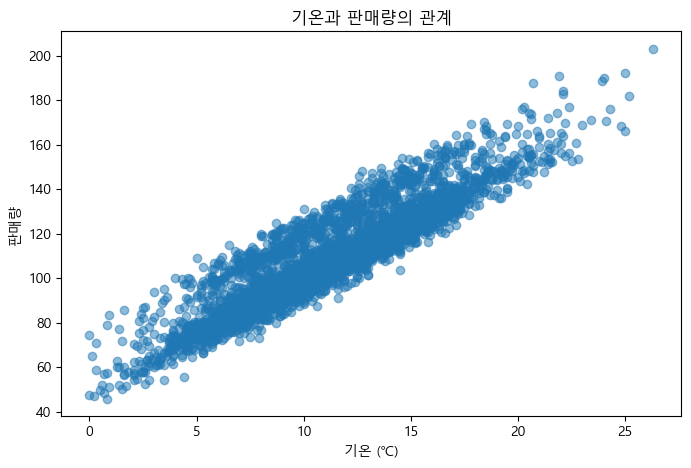

In [10]:
# 산점도: 기온과 판매량의 관계
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 5))
plt.scatter(merged_df['temp'], merged_df['sales'], alpha=0.5)
plt.xlabel("기온 (℃)")
plt.ylabel('판매량')
plt.title('기온과 판매량의 관계')
plt.show()

# 3. 기본 모델링 (RandomForestRegressor 사용)

In [11]:
# Feature: 기온(temp), 강수량(rainfall), 프로모션 여부(promotion_flag)
features = ['temp', 'rainfall', 'promotion_flag']
X = merged_df[features]
y = merged_df['sales']

In [12]:
# 시계열 데이터이므로 날짜순 정렬 후, train/test split (shuffle=False)
merged_df.sort_values(by='date', inplace=True)
X = merged_df[features]
y = merged_df['sales']
# train/test 분할 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
# 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [15]:
# 예측
y_pred = model.predict(X_test)

# 4. 평가 (RMSE, R^2)

In [17]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("\n테스트 세트 평가 결과:")
print('RMSE:', rmse)
print('R^2:', r2)


테스트 세트 평가 결과:
RMSE: 5.681601223309225
R^2: 0.9388072546446169


# 5. 결과 해석 및 시각화

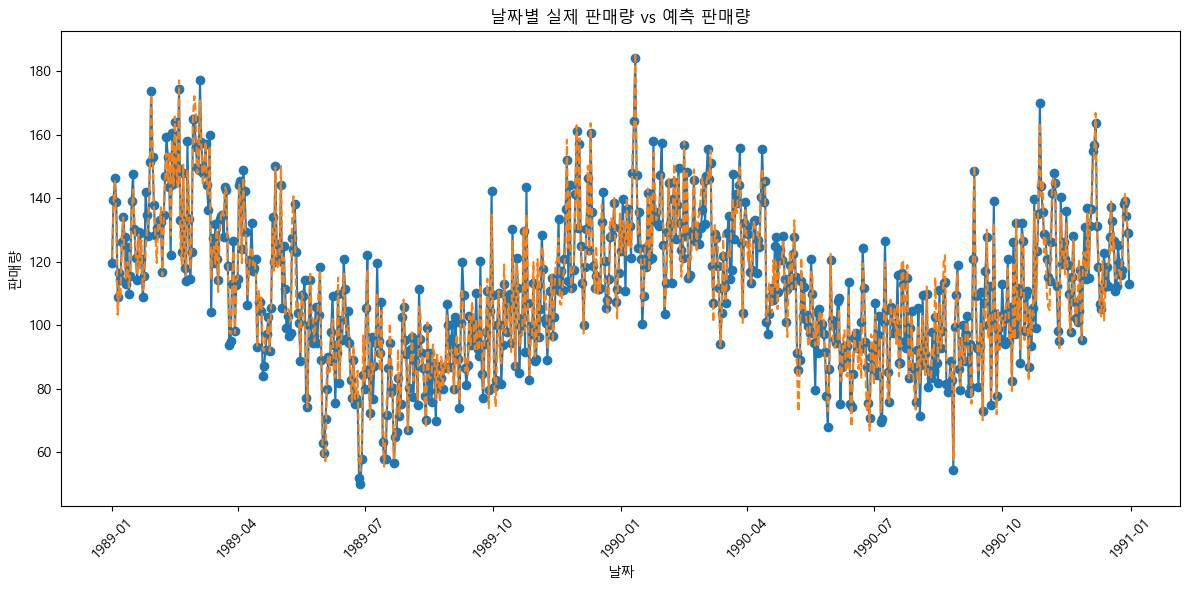

In [18]:
# 날짜별 실제 판매량과 예측 판매량 라인 차트
# test set에 해당하는 날짜 추출
dates_test = merged_df['date'].iloc[len(X_train):]

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label='실제 판매량', marker='o')
plt.plot(dates_test, y_pred, label='예측 판매량', linestyle='--')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.title('날짜별 실제 판매량 vs 예측 판매량')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 결과 해석

- **상관관계:**
    - 기온과 판매량 간의 상관관계가 약 0.91로 매우 높아, 기온이 판매량에 큰 영향을 미친다는 것을 확인할 수 있습니다.
- **모델 성능:**
    - 테스트 세트에서 RMSE 약 5.68, R² 약 0.94의 성능을 보여 모델이 데이터를 잘 설명하고 있음을 알 수 있습니다.
- **종합:**
    - 단순한 합성 데이터를 사용했음에도 불구하고, 실제로 기온과 프로모션 등의 피처가 판매에 미치는 영향을 효과적으로 포착하는 모델링 과정과 결과를 확인할 수 있습니다.